### 3.1 Part 1 - Time windows
In this part you will be collecting data from the Reddit stream API. This data
will be used for analyses. You will modify and use the class RedditListener in
the provided template code.


**Task 1.2 - Data analyses (20 marks)** Using the data contained in the CSV
file you generated in the previous task:




In [1]:
#Import necessary packages 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Read 4 hour reddit data csv
df = pd.read_csv("reddit_data.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'])
df.head()


,author,id,submission,body,subreddit,created_utc,collected_utc
0,qq6vw7hg,ka5o4yf,180h2by,"Yes, joined the police six years ago.\n\nWas a...",AskUK,2023-11-21 13:46:40,2023-11-21 13:46:52.059059
1,txlfg56s,ka5o6eo,180d1nv,"Hands down, PICKLED ONION MONSTER MUNCH!",AskUK,2023-11-21 13:46:59,2023-11-21 13:47:11.215984
2,ytf3a,ka5o75s,1800g7g,Alan Powell from Quantico I think they mean.,AskUK,2023-11-21 13:47:08,2023-11-21 13:47:21.800755
3,13ix2q3t,ka5o7so,17zyi6j,Heard a lot of people say this and I agree it ...,AskUK,2023-11-21 13:47:16,2023-11-21 13:47:27.657967
4,kds40nwe,ka5o8du,7ukir1,"If you have to duck out, for whatever reason, ...",AskUK,2023-11-21 13:47:24,2023-11-21 13:47:38.248998


• (10 marks) Calculate and plot the Number of unique users in each
subreddit using a (i) a tumbling window of length 20 minutes and (ii)
a hopping window of length 20 minutes with a hop of size 5 minutes.
Comment upon the differences you observed in the data comparing the
two subreddits.


In [3]:
#This cell calculates the number of unique users in each subreddit using tumbling and hopping windows

#Tumbling window of length 20 minutes
tumbling_window = df.groupby(['subreddit', pd.Grouper(key='created_utc', freq='20T', origin='start')])['author'].nunique()
tumbling_window_df = tumbling_window.reset_index()
tumbling_window_df.columns = ['subreddit', 'timestamp', 'unique_authors']  
#print(tumbling_window_df)

hopping_window = df.groupby(['subreddit', pd.Grouper(key='created_utc', freq='5T', origin='start')])['author'].agg(set)
hopping_window_df = hopping_window.reset_index()
hopping_window_df.columns = ['subreddit', 'timestamp', 'unique_authors']  
#print(hopping_window_df)

#Calculate the sum of unique authors in a hopping window of 20 minutes with a hop of 5 minutes
window_size = 4 
for i in range(len(hopping_window_df)):
    unique_authors_count = set()
    for j in range(i, min(i + window_size, len(hopping_window_df))):
        unique_authors_count |= hopping_window_df.at[j, 'unique_authors']
    #print(total_unique_authors)
    hopping_window_df.at[i, 'unique_authors_count'] = len(unique_authors_count)

hopping_window_df = hopping_window_df.groupby('subreddit').apply(lambda x: x.iloc[:-3]).reset_index(drop=True)
#print(hopping_window_df)

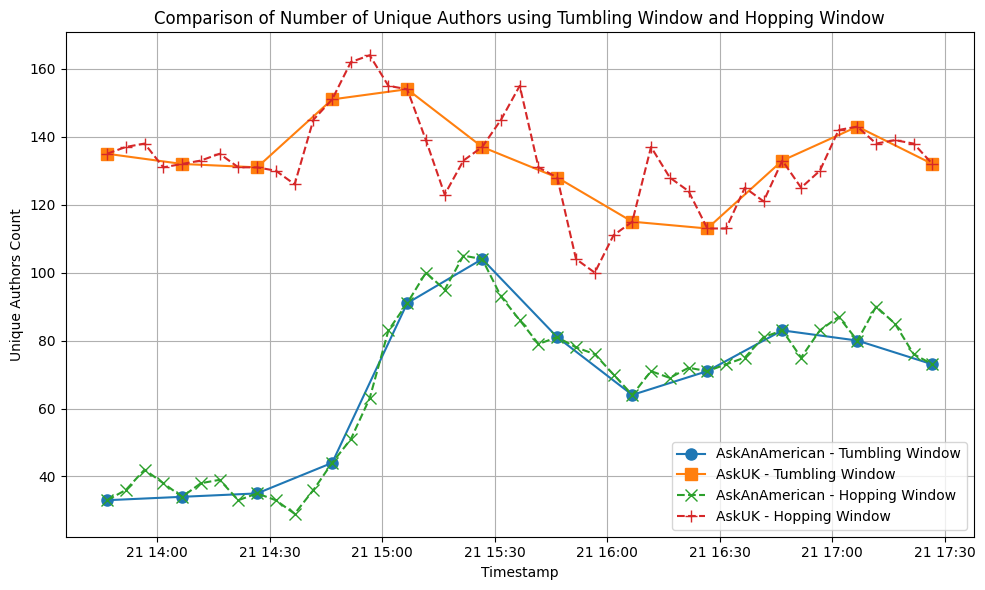

In [4]:
#Plot the number of unique users in each subreddit using tumbling and hopping windows
tumbling_markers = ['o', 's']  
hopping_markers = ['x', '+']  

#Plotting Tumbling Window
plt.figure(figsize=(10, 6))
for i, (subreddit, data) in enumerate(tumbling_window_df.groupby('subreddit')):
    plt.plot(data['timestamp'], data['unique_authors'], 
             label=subreddit + ' - Tumbling Window', 
             marker=tumbling_markers[i], markersize=8)

#Plotting Hopping Window
for i, (subreddit, data) in enumerate(hopping_window_df.groupby('subreddit')):
    plt.plot(data['timestamp'], data['unique_authors_count'], 
             label=subreddit + ' - Hopping Window', 
             linestyle='--', marker=hopping_markers[i], markersize=8)

plt.xlabel('Timestamp')
plt.ylabel('Unique Authors Count')
plt.title('Comparison of Number of Unique Authors using Tumbling Window and Hopping Window')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the plot above we can see that the hoping window tends to vary more than the tumbling window, which is to be expected as there are more data points. Data points overlap every 20 minutes as the windows for those data points are the same. Both windows provide insights into the count of unique authors over time. The plot clearly shows that the AskUK subreddit receives significantly more comments than the AskAnAmerican subreddit at all timestamps. It may be that the time of day influences the activity of these two subreddits. If this is the case then the relationship may be the opposite at another time of day.

• (10 marks) Calculate and plot the Average number of words per
comment for each subreddit using (i) a tumbling window of length
20 minutes and (ii) a hopping window of length 20 minutes with a hop
of size 5 minutes. Comment upon the differences you observed in the data
comparing the two window types.

In [5]:
#Calculate the number of words in the 'body' column
df['num_words'] = df['body'].str.split().apply(len)
#print(df.head())
#Calculate the average number of words for comments in a Tumbling Window
tumbling_window = df.groupby(['subreddit', pd.Grouper(key='created_utc', freq='20T', origin='start')])['num_words'].mean()
tumbling_window_df = tumbling_window.reset_index()
tumbling_window_df.columns = ['subreddit', 'timestamp', 'avg_words']  
#print(tumbling_window_df)


#Hopping window 
hopping_window = df.groupby(['subreddit', pd.Grouper(key='created_utc', freq='5T', origin='start')])['num_words'].mean()
hopping_window_df = hopping_window.reset_index()
hopping_window_df.columns = ['subreddit', 'timestamp', 'avg_words']  

#print(hopping_window_df)

#Calculate the average number of words for comments in a hopping window of 20 minutes with a hop of 5 minutes
for i in range(len(hopping_window_df)):
    total_avg_words = 0
    for j in range(i, min(i + 4, len(hopping_window_df))):
        total_avg_words += hopping_window_df.at[j, 'avg_words']
    hopping_window_df.at[i, 'sum_avg_words'] = total_avg_words / 4


hopping_window_df = hopping_window_df.groupby('subreddit').apply(lambda x: x.iloc[:-3]).reset_index(drop=True)
#print(hopping_window_df)

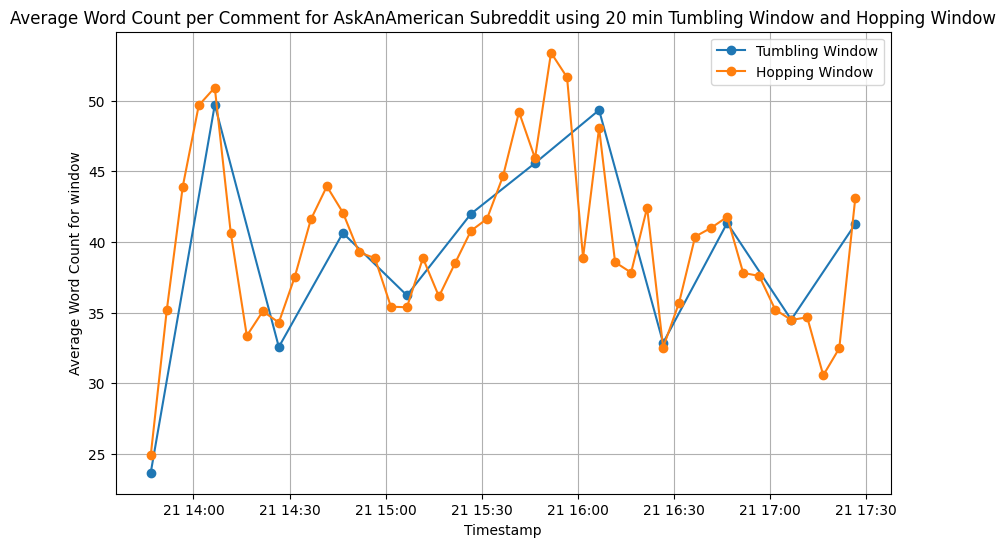

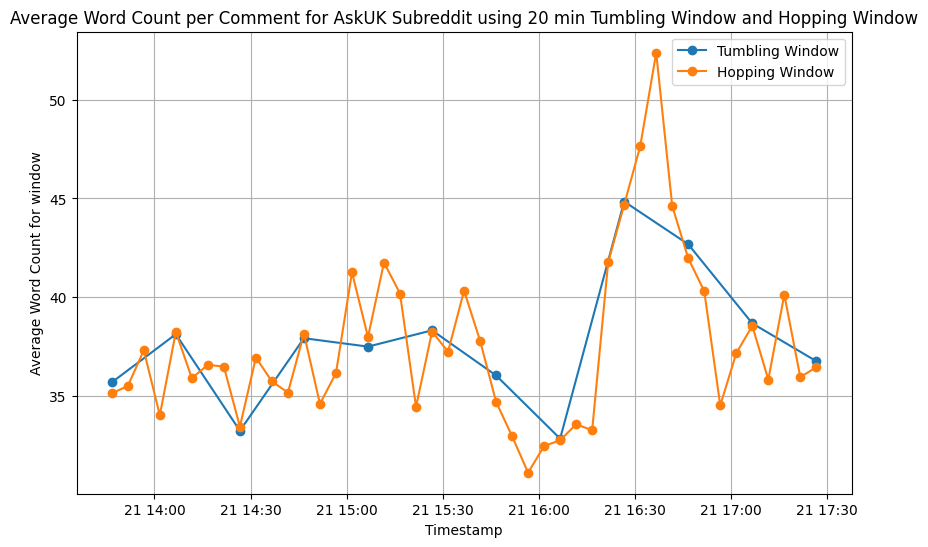

In [6]:
#Plotting tumbling_window_df and hopping_window_df unique author counts
subreddits = tumbling_window_df['subreddit'].unique()

for i, subreddit in enumerate(subreddits):
    plt.figure(figsize=(10, 6))
    data = tumbling_window_df[tumbling_window_df['subreddit'] == subreddit]
    plt.plot(data['timestamp'], data['avg_words'], label= "Tumbling Window", marker="o")
    data = hopping_window_df[hopping_window_df['subreddit'] == subreddit]
    plt.plot(data['timestamp'], data['sum_avg_words'], label= "Hopping Window", marker="o")   
    plt.xlabel('Timestamp')
    plt.ylabel('Average Word Count for window')
    plt.title(f'Average Word Count per Comment for {subreddit} Subreddit using 20 min Tumbling Window and Hopping Window')
    plt.legend()
    plt.grid(True)
    plt.show()

In the plots above we can see the evolution of the average word count in comments for both subreddits over time using tumbling and hopping windows. The hopping window values tend to vary more than the ones from the tumbling window due to there being more of them, this leads to greater spike and drops in the hopping window than the tumbling window. The comparison of both types of windows allows us to get a more precise understanding of the time at which the average word count was highest (around 16:35) and lowest (around 16:05).